# Analysis of Zenodo data

## Import of packages

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

## Load data

In [115]:
datasets = pd.read_csv("datasets.tsv", sep="\t")
files = pd.read_csv("files.tsv", sep="\t")

C:\Users\bouar\miniconda3\envs\mdws\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [116]:
tab = pd.merge(datasets, files, on=["dataset_id", "origin"])

In [117]:
tab.head()
#print(len(tab))

,dataset_id,origin,doi,date_creation,date_last_modified,date_fetched,file_number,download_number,view_number,access_right,...,title,author,keywords,file_type,file_size,file_md5,from_zip_file,file_name,file_url,origin_zip_file
0,3604282,zenodo,10.5281/zenodo.3604282,2020-01-10,2020-01-24,2022-01-04T00:56:05,22,101,8,open,...,Small membranes crowded with proteins at diffe...,"Javanainen, Matti",NaN,cpt,4.094080e+05,8d199727fe137886cc582781ba64d604,False,M-4-400-300.cpt,https://zenodo.org/api/files/79746ec1-ad28-4e6...,None
1,3604282,zenodo,10.5281/zenodo.3604282,2020-01-10,2020-01-24,2022-01-04T00:56:05,22,101,8,open,...,Small membranes crowded with proteins at diffe...,"Javanainen, Matti",NaN,edr,1.344147e+07,989fa719a1a9986b24b4b4dd18dfa8a5,False,M-4-400-300.edr,https://zenodo.org/api/files/79746ec1-ad28-4e6...,None
2,3604282,zenodo,10.5281/zenodo.3604282,2020-01-10,2020-01-24,2022-01-04T00:56:05,22,101,8,open,...,Small membranes crowded with proteins at diffe...,"Javanainen, Matti",NaN,gro,1.171116e+06,4edcd5d462aca6374a3804835d796646,False,M-4-400-300.gro,https://zenodo.org/api/files/79746ec1-ad28-4e6...,None
3,3604282,zenodo,10.5281/zenodo.3604282,2020-01-10,2020-01-24,2022-01-04T00:56:05,22,101,8,open,...,Small membranes crowded with proteins at diffe...,"Javanainen, Matti",NaN,tpr,8.403920e+05,c36a4260a857a38f73a78693a44b7828,False,M-4-400-300.tpr,https://zenodo.org/api/files/79746ec1-ad28-4e6...,None
4,3604282,zenodo,10.5281/zenodo.3604282,2020-01-10,2020-01-24,2022-01-04T00:56:05,22,101,8,open,...,Small membranes crowded with proteins at diffe...,"Javanainen, Matti",NaN,xtc,1.177116e+09,4a5b38d1b65136d7d1538ac5e36ee436,False,M-4-400-300.xtc,https://zenodo.org/api/files/79746ec1-ad28-4e6...,None


In [118]:
tab.shape

(175415, 21)

## New columns in the dataframe

In [119]:
def read_query_file():
    """File query.yml parser.

    This function parses the query file.

    Returns
    -------
    file_types : dict
        Dictionary with type, engine, keywords to use and category
    """
    with open("query.yml", "r") as param_file:
        data_loaded = yaml.safe_load(param_file)
    file_types = data_loaded["file_types"]
    return file_types

In [120]:
dico_file_types = read_query_file()

ext_gromacs = []
ext_namd = []
ext_amber = []

list_coordinate = []
list_trajectory = []
list_topology = []
for dico in dico_file_types:
    if dico["engine"] == "gromacs":
        ext_gromacs.append(dico["type"])
    elif dico["engine"] == "namd":
        ext_namd.append(dico["type"])
    elif dico["engine"] == "amber":
        ext_amber.append(dico["type"])
    ext_all = ext_gromacs + ext_namd + ext_amber
    
    if dico["category"] == "coordinate":
        list_coordinate.append(dico["type"])
    elif dico["category"] == "topology":
        list_topology.append(dico["type"])
    elif dico["category"] == "trajectory":
        list_trajectory.append(dico["type"])
    
# The filetype "top" is included in Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

In [121]:
tab["engine_MD"] = tab["file_type"].apply(lambda x: (x in ext_gromacs and "gromacs") or (x in ext_namd and "namd") or (x in ext_amber and "amber") or "none")
tab["category"] = tab["file_type"].apply(lambda x: (x in list_coordinate and "coordinate") or (x in list_topology and "topology") or (x in list_trajectory and "trajectory") or "none")

In [122]:
tab["years"] = tab["date_creation"].apply(lambda x: int(x[:4]))
datasets["years"] = datasets["date_creation"].apply(lambda x: int(x[:4]))

In [123]:
tab = tab[tab["file_type"] != "zip"] # remove the zip file type
tab.shape

(174546, 24)

Calculation of the total size of the files (in TB) :

In [124]:
print(tab["file_size"].sum()/10**9)

36587.634784064205


Average number of files per dataset :

In [125]:
print(tab.groupby(["dataset_id"])["file_md5"].size().mean())

216.02227722772278


## Analysis

### Number of extensions per MD engine

Text(0, 0.5, 'Number of files')

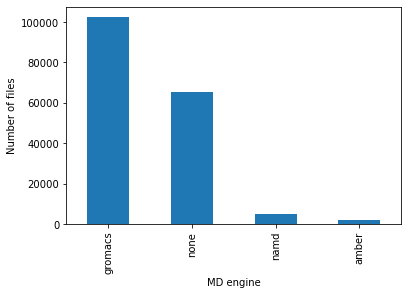

In [126]:
tab["engine_MD"].value_counts().plot(kind = "bar")
plt.xlabel("MD engine")
plt.ylabel("Number of files")

Text(0, 0.5, 'Number of files')

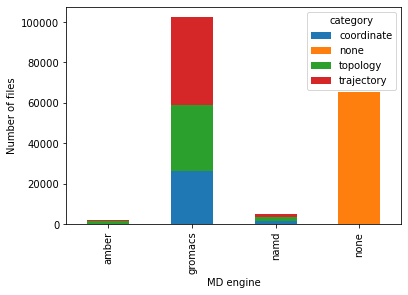

In [127]:
tab.groupby("engine_MD")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("MD engine")
plt.ylabel("Number of files")

#### Number of datatsets per years

Text(0, 0.5, 'Number of datasets')

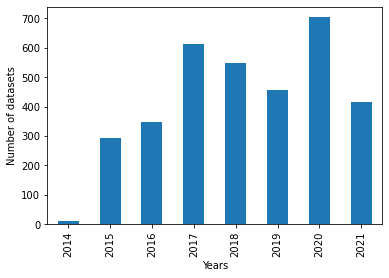

In [129]:
datasets.groupby(["years"])["dataset_id"].size().plot(kind="bar")
plt.xlabel("Years")
plt.ylabel("Number of datasets")

### Number of files per years

Text(0, 0.5, 'Number of files')

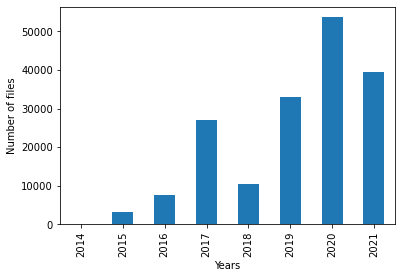

In [132]:
tab["years"].value_counts().sort_index().plot(kind = "bar")
plt.xlabel("Years")
plt.ylabel("Number of files")

Text(0, 0.5, 'Number of files')

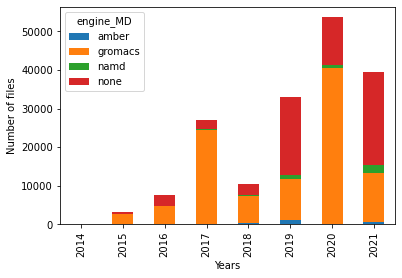

In [133]:
tab.groupby(["years", "engine_MD"]).size().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Years")
plt.ylabel("Number of files")

Text(0, 0.5, 'Number of files')

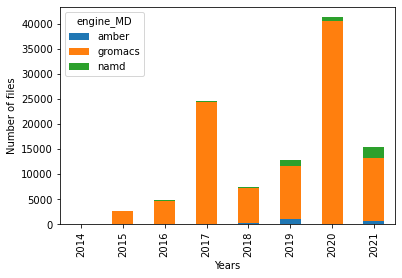

In [155]:
tab[tab["engine_MD"] != "none"].groupby(["years", "engine_MD"]).size().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Years")
plt.ylabel("Number of files")

### Number of files per filetype

Text(0, 0.5, 'Number of files')

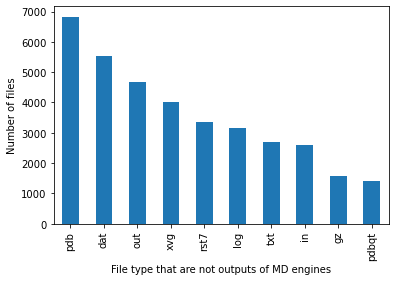

In [156]:
tab[tab["engine_MD"] == "none"]["file_type"].value_counts().head(n=10).plot(kind="bar")
plt.xlabel("File type that are not outputs of MD engines")
plt.ylabel("Number of files")

#### For Gromacs :

Text(0, 0.5, 'Number of files')

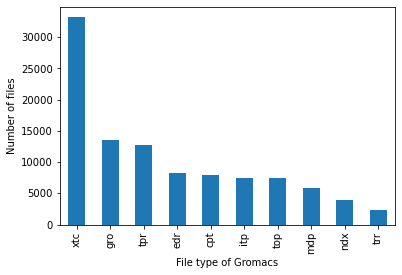

In [157]:
data_gromacs = tab[tab["file_type"].isin(ext_gromacs)]
data_gromacs["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File type of Gromacs")
plt.ylabel("Number of files")

#### For Namd :

Text(0, 0.5, 'Number of files')

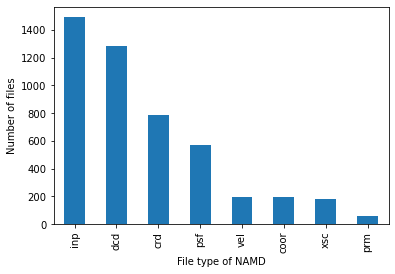

In [158]:
data_namd = tab[tab["file_type"].isin(ext_namd)]
data_namd["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File type of NAMD")
plt.ylabel("Number of files")

#### For Amber :

Text(0, 0.5, 'Number of files')

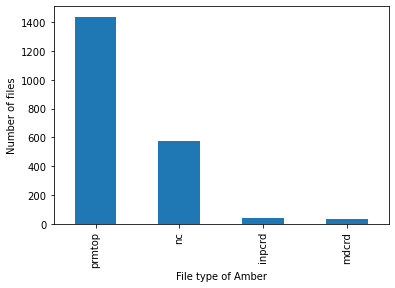

In [159]:
data_amber = tab[tab["file_type"].isin(ext_amber)]
data_amber["file_type"].value_counts().plot(kind = "bar")
plt.xlabel("File type of Amber")
plt.ylabel("Number of files")

#### File size per year

In [160]:
(tab.groupby(["years"])["file_size"].sum()/10**9)

years
2014        5.412649
2015      348.457758
2016      646.526443
2017     7962.815296
2018     5741.348735
2019     5946.786139
2020    11748.097845
2021     4188.189920
Name: file_size, dtype: float64

Text(0, 0.5, 'File size (in TB)')

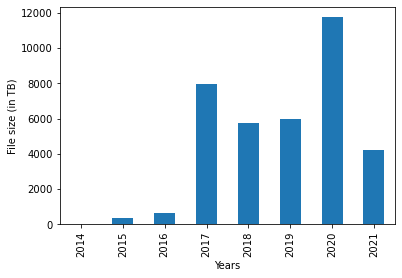

In [161]:
(tab.groupby(["years"])["file_size"].sum()/10**9).plot(kind="bar") 
# store the result in an intermediate df, then divide by 10^9 to have it in TB
plt.xlabel("Years")
plt.ylabel("File size (in TB)")

#### File size per MD engine

Text(0, 0.5, 'File size (in TB)')

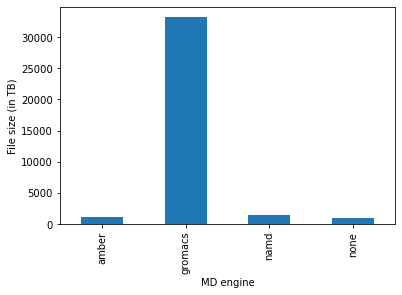

In [162]:
(tab.groupby(["engine_MD"])["file_size"].sum()/10**9).plot(kind="bar")
plt.xlabel("MD engine")
plt.ylabel("File size (in TB)")

<AxesSubplot:xlabel='engine_MD'>

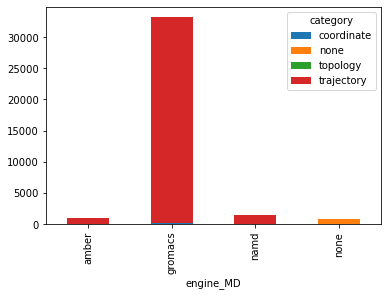

In [163]:
(tab.groupby(["engine_MD", "category"])["file_size"].sum()/10**9).unstack("category").plot(kind="bar", stacked=True)
